<a href="https://colab.research.google.com/github/dongzooo/Quant-with-py/blob/main/%EC%BA%94%EB%93%A4%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%EC%84%9D/%EC%A2%85%EB%AA%A9%EB%B3%84_%EC%88%98%EC%9D%B5%EC%8B%A4%ED%98%84_%EC%A7%84%EC%9E%85%EC%9E%90%EB%A6%AC_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔥매수시점 분석

### 1. Import 및 데이터 파일 불러오기

In [ ]:
import yfinance as yf
import pandas as pd
import datetime
from google.colab import files

import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
matplotlib.rc('axes', unicode_minus=False)

In [ ]:
files.upload()

### 2. 수익시점 데이터 업로드

In [ ]:
#수익 목록 업로드
profitRecord = pd.read_csv(f"/content/gainsTransactions.csv")
profitRecord = profitRecord.drop(profitRecord.columns[0], axis=1)
profitRecord.columns = ['Timestamp', 'Order', 'Code', 'Name', 'price']
profitRecord['Timestamp'] = pd.to_datetime(profitRecord['Timestamp'], format="%y-%m-%d %H:%M:%S")
profitRecord = profitRecord.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

In [ ]:
#종목별로 파일을 불러 알고리즘을 돌리기위해 종목명만 담은 알고리즘을 생성했다.
tempProfitRecord = profitRecord
stocks = tempProfitRecord["Name"].tolist()
stocks

In [ ]:
#기존 분봉데이터와 진입시점 비교하기 위해 초데이터 0으로 초기화
profitRecord["Timestamp"] = profitRecord["Timestamp"].dt.floor("Min")
profitRecord

,Timestamp,Order,Code,Name,price
0,2023-06-15 09:32:00,현금매수,900250,크리스탈신소재,4275
1,2023-06-15 09:59:00,현금매수,42700,한미반도체,28439
2,2023-06-15 10:05:00,현금매수,348080,큐라티스,5790
3,2023-06-15 10:20:00,현금매수,250000,보라티알,21650
4,2023-06-15 10:20:00,현금매수,6880,신송홀딩스,14700
5,2023-06-15 10:26:00,현금매수,2140,고려산업,4655
6,2023-06-15 10:36:00,현금매수,6880,신송홀딩스,15150
7,2023-06-15 10:41:00,현금매수,7540,샘표,72800
8,2023-06-15 10:47:00,현금매수,323280,태성,2441
9,2023-06-15 11:05:00,현금매수,372910,한컴라이프케어,6530


### 3. 분석 메서드

#### 3.1 변곡 발생한 인덱스 서치하는 메서드

In [ ]:
# 변곡발생만 검색
def findInflection(n, df, col_name):
    turning_points = []
    start_num = n + 1
    for i in range(start_num, len(df)):
      # 변곡 발생
      if (df[col_name].iloc[i] > df[col_name].iloc[i - 1] <= df[col_name].iloc[i - 2]):
              turning_points.append(i)
    return turning_points

### 3.2 수익시점에 거래지표 생성 및 정규화

In [ ]:
def getProfitPoint(i):
  df1Min = pd.read_csv(f"/content/ytd1MinData{stocks[i]}.csv")
  df1Min = df1Min.drop(df1Min.columns[0], axis=1)
  df1Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df1Min['Timestamp'] = pd.to_datetime(df1Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df1Min = df1Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)
  df1Min["Name"] = profitRecord.loc[i]["Name"]

  df3Min = pd.read_csv(f"/content/ytd3MinData{stocks[i]}.csv")
  df3Min = df3Min.drop(df3Min.columns[0], axis=1)
  df3Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df3Min['Timestamp'] = pd.to_datetime(df3Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df3Min = df3Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

  df10Min = pd.read_csv(f"/content/ytd10MinData{stocks[i]}.csv")
  df10Min = df10Min.drop(df10Min.columns[0], axis=1)
  df10Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df10Min['Timestamp'] = pd.to_datetime(df10Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df10Min = df10Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

  df30Min = pd.read_csv(f"/content/ytd30MinData{stocks[i]}.csv")
  df30Min = df30Min.drop(df30Min.columns[0], axis=1)
  df30Min.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close','Volume']
  df30Min['Timestamp'] = pd.to_datetime(df30Min['Timestamp'], format="%y-%m-%d %H:%M:%S")
  df30Min = df30Min.drop_duplicates().sort_values('Timestamp').reset_index(drop=True)

  '''1분봉 '''
  #거래 이평선
  df1Min['2VMA'] = df1Min['Volume'].rolling(window=2).mean()
  df1Min['5VMA'] = df1Min['Volume'].rolling(window=5).mean()
  df1Min['10VMA'] = df1Min['Volume'].rolling(window=10).mean()
  df1Min['20VMA'] = df1Min['Volume'].rolling(window=20).mean()
  df1Min['1Min_5VMA우상향'] = df1Min['5VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
  df1Min['1Min_20VMA우상향'] = df1Min['20VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
    #df1Min 정배열
  df1Min['1Min5_20VMA정배열'] = df1Min.apply(lambda row: 1 if row['5VMA'] > row['20VMA'] else 0, axis=1)
  df1Min['1Min2_5_10_20VMA정배열'] = df1Min.apply(lambda row: 1 if row['2VMA'] > row['5VMA'] > row['10VMA'] > row['20VMA'] else 0, axis=1)

  '''3분봉'''
  #거래 이평선 생성
  df3Min['2VMA'] = df3Min['Volume'].rolling(window=2).mean()
  df3Min['5VMA'] = df3Min['Volume'].rolling(window=5).mean()
  df3Min['10VMA'] = df3Min['Volume'].rolling(window=10).mean()
  df3Min['20VMA'] = df3Min['Volume'].rolling(window=20).mean()
    #df3Min 정배열
  df3Min['3Min5_20VMA정배열'] = df3Min.apply(lambda row: 1 if row['5VMA'] > row['20VMA'] else 0, axis=1)
  df3Min['3Min2_5_10_20VMA정배열'] = df3Min.apply(lambda row: 1 if row['2VMA'] > row['5VMA'] > row['10VMA'] > row['20VMA'] else 0, axis=1)

  '''10분봉'''
  #거래 이평선 생성
  df10Min['2VMA'] = df10Min['Volume'].rolling(window=2).mean()
  df10Min['3VMA'] = df10Min['Volume'].rolling(window=3).mean()
  df10Min['10Min2_3VMA정배열'] = df10Min.apply(lambda row: 1 if row['2VMA'] > row['3VMA'] else 0, axis=1)
  df10Min['10Min_2VMA우상향'] = df10Min['2VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
  df10Min['10Min_3VMA우상향'] = df10Min['3VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)

  #거래이평 변곡
  df10MinInf = pd.DataFrame(columns=df10Min.columns)
  turning_points = findInflection(2,df10Min,"2VMA")
  for i in turning_points:
    df10MinInf = df10MinInf._append(df10Min.iloc[i],ignore_index=True)

  df10Min['10M_2VMA변곡'] = 0
  df10Min.loc[df10Min['Timestamp'].isin(df10MinInf['Timestamp']), '10M_2VMA변곡'] = 1

  '''30분봉'''
  #거래 이평선 생성
  df30Min['2VMA'] = df30Min['Volume'].rolling(window=2).mean()
  df30Min['3VMA'] = df30Min['Volume'].rolling(window=3).mean()
  df30Min['30Min2_3VMA정배열'] = df30Min.apply(lambda row: 1 if row['2VMA'] > row['3VMA'] else 0, axis=1)
  df30Min['30Min_2VMA우상향'] = df30Min['2VMA'].pct_change().apply(lambda x: 1 if x > 0 else 0)

  #거래이평 변곡
  df30MinInf = pd.DataFrame(columns=df30Min.columns)
  turning_points = findInflection(2,df30Min,"2VMA")
  for i in turning_points:
    df30MinInf = df30MinInf._append(df30Min.iloc[i],ignore_index=True)

  df30Min['30M_2VMA변곡'] = 0
  df30Min.loc[df30Min['Timestamp'].isin(df30MinInf['Timestamp']), '30M_2VMA변곡'] = 1

  #3,10,30분봉과 1분봉 시계열 시작 맞추기 + 우상향생성
  df1Min['Timestamp'].iloc[0]
  df3Min = df3Min[df3Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
  df3Min = df3Min.reset_index(drop=True)

  df10Min = df10Min[df10Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
  df10Min['2VMA우상향'] = df10Min['2VMA'].pct_change().apply(lambda x: 1 if x >= 0 else 0)
  df10Min = df10Min.reset_index(drop=True)

  df30Min = df30Min[df30Min['Timestamp'] >= df1Min['Timestamp'].iloc[0]]
  df30Min['2VMA우상향'] = df30Min['2VMA'].pct_change().apply(lambda x: 1 if x > 0 else 0)
  df30Min = df30Min.reset_index(drop=True)


  #df1Min에 정배열 정의
  #df1Min에 3분봉 10분봉 30분봉 시간선 데이터 추가
  df1Min['3분단위'] = df1Min['Timestamp'].dt.floor('3min')
  df1Min['10분단위'] = df1Min['Timestamp'].dt.floor('10min')
  df1Min['30분단위'] = df1Min['Timestamp'].dt.floor('30min')

  #df1Min 에 넣을 데이터들
  df1Min["3Min5_20VMA정배열"] = 0
  df1Min['10M_2VMA우상향'] = 0
  df1Min['30M_2VMA우상향'] = 0
  df1Min['10Min2_3VMA정배열'] = 0
  df1Min['10Min_2VMA우상향'] = 0
  df1Min['10Min_3VMA우상향'] = 0
  df1Min['30Min2_3VMA정배열'] = 0
  df1Min['30Min_2VMA우상향'] = 0
  df1Min['3Min2_5_10_20VMA정배열'] = 0

  for i in range(len(df3Min)):
      timestamp = df3Min.loc[i, 'Timestamp']
      mask = df1Min['3분단위'] == timestamp
      df1Min.loc[mask, '3Min5_20VMA정배열'] = df3Min.loc[i, '3Min5_20VMA정배열']
      df1Min.loc[mask, '3Min2_5_10_20VMA정배열'] = df3Min.loc[i, '3Min2_5_10_20VMA정배열']


  for i in range(len(df10Min)):
      timestamp = df10Min.loc[i, 'Timestamp']
      mask = df1Min['10분단위'] == timestamp
      df1Min.loc[mask, '10M_2VMA우상향'] = df10Min.loc[i, '2VMA우상향']
      df1Min.loc[mask, '10Min2_3VMA정배열'] = df10Min.loc[i, '10Min2_3VMA정배열']
      df1Min.loc[mask, '10M_2VMA변곡'] = df10Min.loc[i, '10M_2VMA변곡']
      df1Min.loc[mask, '10Min_2VMA우상향'] = df10Min.loc[i, '10Min_2VMA우상향']
      df1Min.loc[mask, '10Min_3VMA우상향'] = df10Min.loc[i, '10Min_3VMA우상향']


  for i in range(len(df30Min)):
      timestamp = df30Min.loc[i, 'Timestamp']
      mask = df1Min['30분단위'] == timestamp
      df1Min.loc[mask, '30M_2VMA우상향'] = df30Min.loc[i, '2VMA우상향']
      df1Min.loc[mask, '30Min2_3VMA정배열'] = df30Min.loc[i, '30Min2_3VMA정배열']
      df1Min.loc[mask, '30M_2VMA변곡'] = df30Min.loc[i, '30M_2VMA변곡']
      df1Min.loc[mask, '30Min_2VMA우상향'] = df30Min.loc[i, '30Min_2VMA우상향']

  # filtered_df = df1Min[df1Min["Timestamp"] == profitRecord.iloc[i]["Timestamp"]]



  return df1Min , profitRecord


In [ ]:
  #'10Min_2VMA우상향','10Min_3VMA우상향','30Min_2VMA우상향','1Min_5VMA우상향','1Min_20VMA우상향','1Min2_5_10_20VMA정배열','3Min2_5_10_20VMA정배열'

In [ ]:
#14시50분 이후 데이터는 날리는 작업은 이평성 생성후 한다
target_time = pd.to_datetime("14:50:00", format="%H:%M:%S").strftime('%H:%M:%S')
result_df = pd.DataFrame()


### 4. 함수 실행

In [ ]:
for i in range(len(stocks)):
  df1Min , profitRecord = getProfitPoint(i)
  df = df1Min[df1Min["Timestamp"] == profitRecord.iloc[i]["Timestamp"]]

  if df.empty:
    print(i,stocks[i],"DataFrame이 비어 있습니다.")
  else:
    print("DataFrame이 비어 있지 않습니다.")

  result_df = pd.concat([result_df, df], axis=0)
  # print(i,end='')

0 크리스탈신소재 DataFrame이 비어 있습니다.
1 한미반도체 DataFrame이 비어 있습니다.
2 큐라티스 DataFrame이 비어 있습니다.
3 보라티알 DataFrame이 비어 있습니다.
4 신송홀딩스 DataFrame이 비어 있습니다.
5 고려산업 DataFrame이 비어 있습니다.
6 신송홀딩스 DataFrame이 비어 있습니다.
DataFrame이 비어 있지 않습니다.
8 태성 DataFrame이 비어 있습니다.
9 한컴라이프케어 DataFrame이 비어 있습니다.
10 대봉엘에스 DataFrame이 비어 있습니다.
11 피코그램 DataFrame이 비어 있습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.
DataFrame이 비어 있지 않습니다.


In [ ]:
result_df = result_df.reset_index(drop=True)
# result_df = combined_df
# result_df

### * 이전 매매분석 DF 불러오기

In [ ]:
result_df = pd.read_csv("15_21result_df.csv")
result_df
# 데이터프레임에서 중복 행 제거 후 합치기
# combined_df = pd.concat([result_df1, result_df]).drop_duplicates().reset_index(drop=True)
# combined_df

,Timestamp,Open,High,Low,Close,Volume,Name,2VMA,5VMA,10VMA,...,30M_2VMA우상향,10Min2_3VMA정배열,10Min_2VMA우상향,10Min_3VMA우상향,30Min2_3VMA정배열,30Min_2VMA우상향,3Min2_5_10_20VMA정배열,10M_2VMA변곡,30M_2VMA변곡,0종목명/종목수
0,2023-06-15 09:32:00,4225,4280,4200,4280,544322,크리스탈신소재,378923.0,183339.0,211512.1,...,1,1,1,1,1,1,0,1.0,0.0,1
1,2023-06-15 09:59:00,28450,28500,28350,28350,168758,한미반도체,183881.5,88915.0,63905.7,...,1,0,0,1,1,1,0,0.0,0.0,1
2,2023-06-15 10:05:00,5660,5790,5660,5770,417699,큐라티스,227323.5,124971.4,99419.7,...,0,0,1,0,0,0,0,1.0,0.0,1
3,2023-06-15 10:20:00,21100,22100,21100,22000,161439,보라티알,115267.0,101988.8,65189.8,...,1,1,1,0,1,1,0,1.0,0.0,1
4,2023-06-15 10:20:00,14410,14700,14370,14700,97200,신송홀딩스,80317.0,62059.8,44916.9,...,0,1,1,0,1,0,0,1.0,0.0,1
5,2023-06-15 10:26:00,4600,4745,4600,4745,389288,고려산업,199553.0,88471.6,46414.9,...,1,1,1,1,0,1,1,1.0,0.0,1
6,2023-06-15 10:36:00,14870,15270,14830,14950,186290,신송홀딩스,113754.5,62845.0,63280.8,...,1,1,1,1,0,1,0,0.0,1.0,1
7,2023-06-15 10:41:00,71000,74200,71000,73600,21921,샘표,11591.0,6419.8,4983.2,...,1,1,1,1,1,1,0,0.0,0.0,1
8,2023-06-15 10:47:00,2370,2465,2360,2460,448356,태성,236582.0,99902.0,56202.8,...,1,1,1,1,1,1,0,1.0,0.0,1
9,2023-06-15 11:05:00,6390,6560,6370,6500,113432,한컴라이프케어,59451.0,25205.0,14213.2,...,1,1,1,1,1,1,1,1.0,1.0,1


### 5. 데이터 집계

In [ ]:
columns = ["0종목명/종목수","1Min5_20VMA정배열","3Min5_20VMA정배열",'10Min2_3VMA정배열',"10M_2VMA우상향",'10M_2VMA변곡',
           '30Min2_3VMA정배열',"30M_2VMA우상향",'30M_2VMA변곡','10Min_2VMA우상향','10Min_3VMA우상향','30Min_2VMA우상향','1Min_5VMA우상향','1Min_20VMA우상향','1Min2_5_10_20VMA정배열',
           '3Min2_5_10_20VMA정배열']

# 'Profitable'이 1인 경우의 데이터프레임 추출
# df_profitable_1 = df1MinData[df1MinData['Profitable'] == 1]
# df_profitable_1 = df_profitable_1.reset_index(drop=True)
# len(df_profitable_1)

# 컬럼별로 퍼센트 계산
percentages = []
count = []
result_df["0종목명/종목수"] = 1
for column in columns:
    count.append(result_df[column].sum())
    percentage = (result_df[column].sum() / result_df.shape[0]) * 100
    percentages.append(round(percentage,2))


# 결과를 데이터프레임으로 정리
quant_df = pd.DataFrame({'Column': columns, 'Percentage(%)': percentages, 'Count':count})
quant_df = quant_df.sort_values('Column').reset_index(drop=True)
# quant_df = quant_df.sort_values('Count').reset_index(drop=True)
# quant_df

# 결과 출력
quant_df.sort_values(by='Percentage(%)', ascending=False).reset_index(drop=True)

,Column,Percentage(%),Count
0,0종목명/종목수,100.00,36.0
1,1Min_5VMA우상향,100.00,36.0
2,1Min_20VMA우상향,94.44,34.0
3,1Min5_20VMA정배열,91.67,33.0
4,10M_2VMA우상향,83.33,30.0
5,10Min_2VMA우상향,83.33,30.0
6,10Min2_3VMA정배열,75.00,27.0
7,10Min_3VMA우상향,75.00,27.0
8,30M_2VMA우상향,75.00,27.0
9,30Min_2VMA우상향,75.00,27.0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-pack

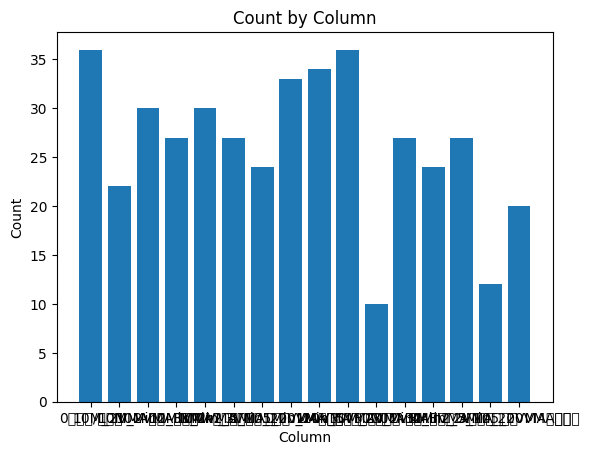

In [ ]:
# 그래프 그리기
plt.bar(quant_df['Column'], quant_df['Count'])
plt.xlabel('Column')
plt.ylabel('Count')
plt.title('Count by Column')

# 그래프 출력
plt.show()

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d")
today = datetime.date.today()
today

datetime.date(2023, 6, 21)

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d")
today = datetime.date.today()
directory = f"./{today.strftime('%Y%m%d')}"
# os.makedirs(directory, exist_ok=True)

#결과 저장
quant_df.to_csv(f"{directory}_quant_df.csv", index=False)
result_df.to_csv(f"{directory}_result_df.csv", index=False)

NameError: ignored

### 다른 날짜 데이터 불러오기 및 저장

In [ ]:
# quant_df = pd.read_csv("20230615_quant_df.csv")
# result_df = pd.read_csv("20230615_result_df.csv")
quant_df1 = pd.read_csv("20230621_quant_df.csv")
result_df1 = pd.read_csv("20230621_result_df.csv")
# result_df1 = pd.read_csv("15_21result_df.csv")

In [ ]:
\
# 데이터프레임에서 중복 행 제거 후 합치기
combined_df = pd.concat([result_df1, result_df]).drop_duplicates().reset_index(drop=True)
combined_df
combined_df.to_csv(f"15_21result_df.csv", index=False)

In [ ]:
result_df

,Timestamp,Name,1Min5_20VMA정배열,3Min5_20VMA정배열,10M_2VMA우상향,30M_2VMA우상향,10Min2_3VMA정배열,30Min2_3VMA정배열,10M_2VMA변곡,30M_2VMA변곡,...,1Min_20VMA우상향,1Min2_5_10_20VMA정배열,3분단위,10분단위,30분단위,10Min_2VMA우상향,10Min_3VMA우상향,30Min_2VMA우상향,3Min2_5_10_20VMA정배열,0종목명/종목수
0,2023-06-15 10:41:00,샘표,1,0,1,1,1,1,0.0,0.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
1,2023-06-15 13:20:00,DB,0,1,1,0,1,0,1.0,NaN,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
2,2023-06-15 14:07:00,대한광통신,1,0,0,0,0,0,0.0,0.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
3,2023-06-15 14:13:00,기가비스,1,0,0,1,0,1,0.0,0.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
4,2023-06-15 14:46:00,보라티알,1,1,1,1,1,1,1.0,1.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
5,2023-06-16 10:00:00,태성,1,1,1,1,1,1,1.0,0.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
6,2023-06-16 10:02:00,이수페타시스,1,0,1,0,0,0,1.0,0.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
7,2023-06-16 10:50:00,레이저쎌,1,1,1,1,1,1,0.0,0.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
8,2023-06-16 11:01:00,피코그램,1,1,1,1,1,1,1.0,1.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
9,2023-06-16 11:51:00,레이저쎌,1,1,1,0,1,0,1.0,0.0,...,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,1
